In [21]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import Word
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV


In [14]:
df = pd.read_csv("./dataset/dataset.csv")

In [15]:
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()
df["title"] = df["title"].apply(clean_str)
# data["content"] = data["content"].apply(clean_str)

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.content).toarray()
labels = df.category_id
features.shape

(2225, 14268)

In [17]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3),
    MultinomialNB(),
    LogisticRegression(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

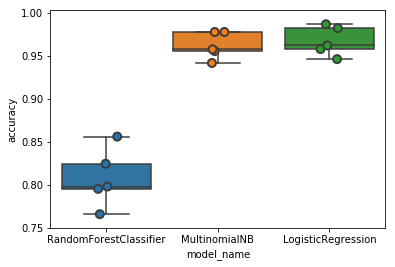

In [18]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [7]:
def evaluate(model):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
    model.fit(X_train, y_train)
#     y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    return y_test, y_pred
def plot(title,y_test, y_pred):
    plt.figure()
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d',)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
def evaluate_vote(models):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
    for model in models:
        model.fit(X_train, y_train)
    y_preds = []
    for model in models:
        y_preds.append(model.predict(X_test))
    y_preds = np.array(y_preds)
    y_preds = y_preds.reshape(y_preds.shape[1], y_preds.shape[0])
    print(y_preds)
    y_pred = [max(list(v), key=list(v).count) for v in y_preds]
    print(y_pred)
    return y_test, y_pred

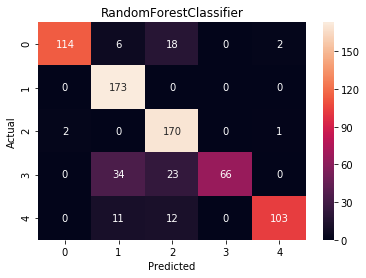

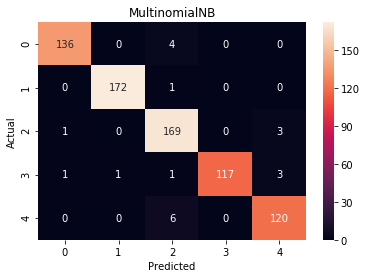

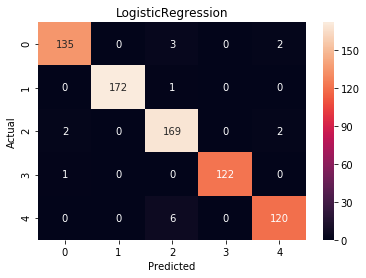

In [8]:
for model in models:
    y_test, y_pred = evaluate(model)
    plot(model.__class__.__name__,y_test, y_pred)
# y_test, y_pred = evaluate_vote(models)
# plot("ensemble", y_test, y_pred)

In [9]:
# left with hyper param tuning 
filename = 'finalized_model.sav'
pickle.dump(models[len(models)-1], open(filename, 'wb'))
pickle.dump(tfidf, open('transformer.sav', 'wb'))

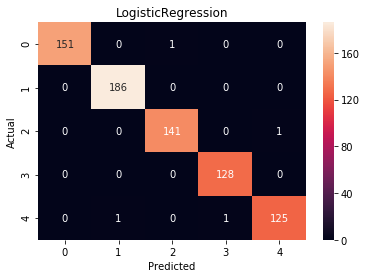

In [10]:
loaded_model = pickle.load(open(filename, 'rb'))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33)
y_pred = loaded_model.predict(X_test)
plot(loaded_model.__class__.__name__,y_test, y_pred)

In [40]:
import text_converter
from preprocessing import reverse_types
text = '''
The special counsel investigating alleged Russian collusion in the 2016 US election will not be pursuing a jail sentence for former national security adviser Michael Flynn.
Mr Flynn has admitted lying to the FBI.
But in a memo, Robert Mueller said Mr Flynn had provided "substantial" details about links between the Trump election team and Russian officials.
The heavily redacted memo hints at future revelations in a criminal probe that could trouble Donald Trump.
President Trump has called the investigation a witch hunt and denies there was any collusion between his team and Russian officials to try to secure his election victory.
The sentencing memo released on Tuesday advising that Mr Flynn should not be imprisoned could have further implications in the ongoing investigation, should other senior members of Mr Trump's team be called upon to co-operate with additional statements.
Mr Flynn is due to be sentenced in the US District Court for the District of Columbia on 18 December.
Mr Mueller's office released the memo as guidance to the judge who will sentence Mr Flynn, the only member of the Trump administration so far to plead guilty as a result of the collusion investigation.
Mr Flynn has pleaded guilty to one count of making materially false statements to the FBI.
He admitted that he discussed lifting US sanctions on Russia with the Russian ambassador to Washington before Mr Trump took office, and that he lied to the US vice-president about that conversation.
It says Mr Flynn has provided assistance in multiple investigations and has also given information on co-ordination between the Russian government and the Trump campaign.
Consequently, it says: "A sentence at the low end of the guideline range - including a sentence that does not impose a term of incarceration - is appropriate and warranted."
The memo points to Mr Flynn's "exemplary" military and public service and that he "deserves credit for accepting responsibility in a timely fashion and substantially assisting the government".
It had been thought details of Russian collusion might be included in the memo but the document says that, due to the "sensitive information about ongoing investigations", certain aspects have been sealed.
An addendum to the memo on Mr Flynn's assistance is heavily redacted.
But it does say Mr Flynn provided "first-hand information about the content and context of interactions between the transition team and Russian government officials" - clearly part of the ongoing investigation.
And then there is this intriguing element. In one section there is the simple sentence "the defendant has provided substantial assistance in a criminal investigation" but everything below it is blacked out.
Analysis by BBC North America reporter Anthony Zurcher
Michael Flynn may end up not spending a day in prison for lying to the FBI about his contacts with Russian officials during the Trump presidential transition.
Part of the reason is because of his clean record prior to this offence. The other part could cause Donald Trump and those close to him sleepless nights in the days ahead.
In an addendum to the sentencing memo, Robert Mueller details the help Mr Flynn provided to his investigation in exchange for a lenient sentence. 
Some of it is old news. The former national security advisor told Mr Mueller "first-hand" about his communications with Russians after Mr Trump's election - and similar communications by others in the transition team.
Buried beneath thick black lines below this "useful information" is an entire section on further help Mr Flynn provided to Mr Mueller's collusion investigation. Even the subhead appears to be redacted.
Then there's a mysterious "criminal investigation" to which Mr Flynn provided "substantial assistance". That portion of the memo, without a few introductory words, is entirely redacted. Who is being investigated? And what type of criminal wrongdoing is suspected?
The Flynn document raises as many questions as it answers - and points toward explosive revelations to come.
He had been a fervent supporter of Mr Trump during the election campaign and was appointed Mr Trump's national security adviser even though former President Barack Obama had warned against the appointment.
It was a short tenure, ending in February 2017 after just 23 days, his departure forced by the revelation he had lied to Vice-President Mike Pence about the discussion with then-Russian ambassador Sergei Kislyak.
Further allegations then arose over a failure to disclose payments from Russian and Turkish lobbyists that he was given for speeches and consulting work.
The retired US Army three-star lieutenant-general had earlier led the Defence Intelligence Agency (DIA) but was fired, on the surface for comments about Islamist extremism, although insiders also pointed to his unpopular overhaul of the agency.
Yes, although not on charges related to collusion with Russia.
Mr Trump's former deputy campaign manager, Rick Gates, has admitted conspiracy and lying to investigators.
Former campaign chairman Paul Manafort has been convicted for fraud, bank fraud and failing to disclose bank accounts. He has a plea bargain deal but has been accused of breaching it by lying to the FBI.
Ex-Trump lawyer Michael Cohen has admitted he lied about a Trump property deal in Russia during the 2016 election.'''
loaded_model = pickle.load(open(filename, 'rb'))
# print(text_converter.raw(text))
# count_vect = CountVectorizer()
# stuffs = count_vect.transform([text])
ntf = pickle.load(open("transformer.sav", 'rb'))
fn = ntf.transform([text])
y_pred = loaded_model.predict(fn)
print(reverse_types[y_pred[0]])

politics


In [24]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33)

# parameter tuning 
hyperparameters = {"tol": np.logspace(1e-8, 5, 100), 
                     "C": np.logspace(0, 10, 20),
                     "penalty": ["l1", "l2"]}
logistic = LogisticRegression()
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(features, labels)

In [36]:
best_model.best_estimator_

LogisticRegression(C=3.3598182862837818, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=1.5922828285233988, verbose=0,
          warm_start=False)

In [37]:
res = best_model.best_estimator_.predict(features)

In [38]:
(res == labels).tolist().count(True)/len(res)

0.9865168539325843

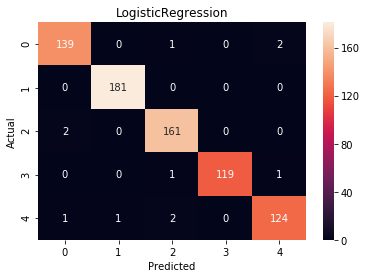

In [39]:
pickle.dump(best_model.best_estimator_, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33)
y_pred = loaded_model.predict(X_test)
plot(loaded_model.__class__.__name__,y_test, y_pred)